project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [1]:

from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa
import flexpart_management.modules.clustering_funs as cfuns

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Loading BokehJS ...

reload


In [2]:
from sklearn.cluster import KMeans

import flexpart_management.modules.clustering_funs as cfuns

N_CLUSTERS = 18


def get_weighted_mean( ds_lab , new_lab_p , weighted_lab ) :
    dims = list( ds_lab[ weighted_lab ].dims )
    if len( dims ) is not 1 :
        raise AttributeError
    dim = dims[ 0 ]
    ds_lab: xr.DataArray
    ds_lab = ds_lab.swap_dims( { dim : weighted_lab } )
    complement = fa.get_dims_complement( ds_lab , weighted_lab )
    da = ds_lab[ new_lab_p ].sum(
        complement )
    da_sum = (da * da[ weighted_lab ]).sum()
    da_tot = da.sum()
    res = da_sum / da_tot
    return res


def weightin_over_dic( df_prop , ds_lab_dic , new_lab_p , weighted_lab ) :
    df_prop[ weighted_lab ] = np.nan
    for ci in range( 18 ) :
        ds_lab = ds_lab_dic[ ci ]
        res = get_weighted_mean( ds_lab , new_lab_p , weighted_lab )
        df_prop.loc[ ci , weighted_lab ] = res

def number_marker_plot( df_prop , x_column ,
                        y_column , ax=None , color='red' ) :
    if ax is None:
        f,ax = plt.subplots()
    df_prop.plot.scatter( x=x_column , y=y_column , alpha=0 , ax=ax )
    for i , r in df_prop.iterrows() :
        # print( i )
        # r_km = r[ co.R_CENTER ]
        # ratio_per = r[ y_column ]
        ax.text(
            x=r[x_column] ,
            y=r[y_column] ,
            s=i , color=color ,
            horizontalalignment='center' ,
            verticalalignment='center' ,

            )

In [3]:

# def main() :
co.LAB = 'lab'

plt.rcParams[ 'figure.facecolor' ] = 'white'

In [4]:

log.ger.setLevel( log.log.DEBUG )

In [5]:
# noinspection PyUnusedLocal,PyShadowingNames
def open_if_taito() :
    # noinspection SpellCheckingInspection
    path = \
        '/homeappl/home/aliagadi/wrk/DONOTREMOVE' \
        '/flexpart_management_data/runs/' \
        'run_2019-10-02_13-42-52_/' \
        'log_pol/run_2019-10-02_13-42-52_'
    # flp = FLP.FlexLogPol(path,concat=True)
    # flp_instance = FLP.FlexLogPol(path,concat=False)
    selfFLP = FlexLogPol.FlexLogPol(
        path ,
        # concat=True,
        concat=False ,
        get_clusters=False ,
        # open_merged=False,
        open_merged=True ,
        # merge_ds=False ,
        # merge_ds=True ,
        clusters_avail=False ,

        # postprocess set to false since we are opening the re interpolated
        # version
        postprocess=False ,

        use_new_merge_fun=True ,

        # set to false bc already done in the saved version
        filter_r_min_max=False ,
        )
    selfFLP.get_list_datasets_saved()
    # noinspection PyUnresolvedReferences
    ds = selfFLP.open_ds_version( 'ds_clustered_18.nc' )
    return selfFLP , ds

In [8]:
# selfFLP,ds = open_if_taito()
# path = '/Users/diego/flexpart_management/flexpart_management/tmp_data' \
#        '/ds_clustered_18.nc'
ds = xr.open_mfdataset(co.latest_ds_mac)
# ds = xr.open_dataset( path )

conc_lab = 'CONC_smooth_t_300_z_25_r_100_th_50'
new_lab_p = 'conc_smooth_p'
new_lab_p_t = 'conc_smooth_p_t'
# cfuns.add_total_per_row( ds , conc_lab , new_lab_p )
# cfuns.add_time_per_row( ds , conc_lab , new_lab_p_t )

/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/Users/diego/miniconda3/envs/b36/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [9]:

ds_lab_dic = { }
for ci in range( N_CLUSTERS ) :
    ds_lab = ds[ [ new_lab_p ] ].where( ds[ co.LAB ] == ci ).copy()
    ds_lab_dic[ ci ] = ds_lab.copy()

In [10]:
x = np.sin( ds[ co.TH_CENTER ] )
x.name = 'X'
# x.plot()
# plt.show()

y = np.cos( -ds[ co.TH_CENTER ] )
y.name = 'Y'
# y.plot()
# plt.show()

In [11]:
# ds_lab_dic = { }
for ci in range( N_CLUSTERS ) :
    # ds_lab = ds[ [ new_lab_p ] ].where( ds[ co.LAB ] == ci ).copy()
    ds_lab = ds_lab_dic[ ci ].copy()
    ds_lab_dic[ ci ] = ds_lab.assign_coords( **{ 'X' : x , 'Y' : y } )

In [12]:
df_prop = pd.DataFrame( range( N_CLUSTERS ) , columns=[ 'cluster_i' ] )
df_prop = df_prop.set_index( 'cluster_i' )

In [ ]:
surface_limit = 1500
ratio_surf_tot_lab = 'ratio_surf_tot'
df_prop[ ratio_surf_tot_lab ] = np.nan
for ci in range( N_CLUSTERS ) :
    ds_lab = ds_lab_dic[ ci ]
    _boo = (ds_lab[ co.ZM ]-ds_lab[co.TOPO]) < surface_limit
    ds_surf = ds_lab.where( _boo )
    ds_surf_sum = ds_surf[ new_lab_p ].sum()
    ds_tot_sum = ds_lab[ new_lab_p ].sum()
    ratio_surf_tot = ds_surf_sum / ds_tot_sum
#     print(ratio_surf_tot)
    df_prop.loc[ ci , ratio_surf_tot_lab ] = ratio_surf_tot

In [ ]:

weighted_lab = co.R_CENTER
weightin_over_dic( df_prop , ds_lab_dic , new_lab_p , weighted_lab )

In [ ]:
weighted_lab = 'X'
weightin_over_dic( df_prop , ds_lab_dic , new_lab_p , weighted_lab )
weighted_lab = 'Y'
weightin_over_dic( df_prop , ds_lab_dic , new_lab_p , weighted_lab )

In [ ]:
weighted_lab = co.ZM
df_prop[ weighted_lab ] = np.nan
for ci in range( N_CLUSTERS ) :
    # print(ci)
    ds_lab = ds_lab_dic[ ci ].copy()
    res = get_weighted_mean( ds_lab , new_lab_p , weighted_lab )
    # print(res)
    df_prop.loc[ ci , weighted_lab ] = res

In [ ]:
zm_topo = 'Z_AG'
weighted_lab = zm_topo
ds_zm_topo = ds[ co.ZM ] - ds[ co.TOPO ]
df_prop[ weighted_lab ] = np.nan
for ci in range( N_CLUSTERS ) :
#     print( ci )
    ds_lab = ds_lab_dic[ ci ].copy()
    ds_lab = ds_lab.assign_coords( **{ weighted_lab : ds_zm_topo } )
    da = ds_lab[ new_lab_p ].sum( co.RL )
    da_sum = (da * da[ weighted_lab ]).sum()
    da_tot = da.sum()
    res = da_sum / da_tot
#     print( res )
    df_prop.loc[ ci , weighted_lab ] = res

In [ ]:
x = df_prop[ 'X' ]
y = df_prop[ 'Y' ]
th = np.arctan2( x , y )
df_prop[ co.TH_CENTER ] = th

In [20]:
clock = 'clock'
cl = df_prop[co.TH_CENTER]*12/(2 *np.pi)
cl:pd.DataFrame = cl.round()
cl = cl.astype(int)
df_prop[clock] = cl



In [21]:
df_path = '/Users/diego/flexpart_management/flexpart_management/tmp_data/prop_df.nc'
df_prop.to_hdf(df_path,key='v01')

In [ ]:

# def scatter_logpolar( ax , theta , r_ , bullseye=0.5 , **kwargs ) :
#     ax.set_theta_zero_location( 'N' )
#     ax.set_theta_direction( -1 )
#     min10 = np.log10( np.min( r_ ) )
#     max10 = np.log10( np.max( r_ ) )
#     r = np.log10( r_ ) - min10 + bullseye
#     t = np.log10( r_ ) - min10 + bullseye
#     ax.scatter( theta , r , **kwargs )
#     l = np.arange( np.floor( min10 ) , max10 , .5 )
#     ax.set_rticks( l - min10 + bullseye )
#     ax.set_yticklabels( [ "1e%f" % x for x in l ] )
#     ax.set_rlim( 0 , 1.5 * max10 - min10 + bullseye )
#     # ax.set_title( 'log-polar manual' )
#     for i , rr in enumerate( r ) :
#         ax.text( theta[ i ] , rr , i )

#     return ax

# f , ax = plt.subplots( 1 , 1 , subplot_kw=dict( polar=True ) )
# scatter_logpolar( ax , df_prop[ co.TH_CENTER ] , df_prop[ co.R_CENTER ] )

# plt.show()

In [ ]:

# f , ax = plt.subplots()
# ax: plt.Axes
# number_marker_plot( df_prop , co.R_CENTER , co.ZM , ax )
# plt.show()

In [22]:
ucp.set_dpi(300)
plt.style.use('seaborn-whitegrid')
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True

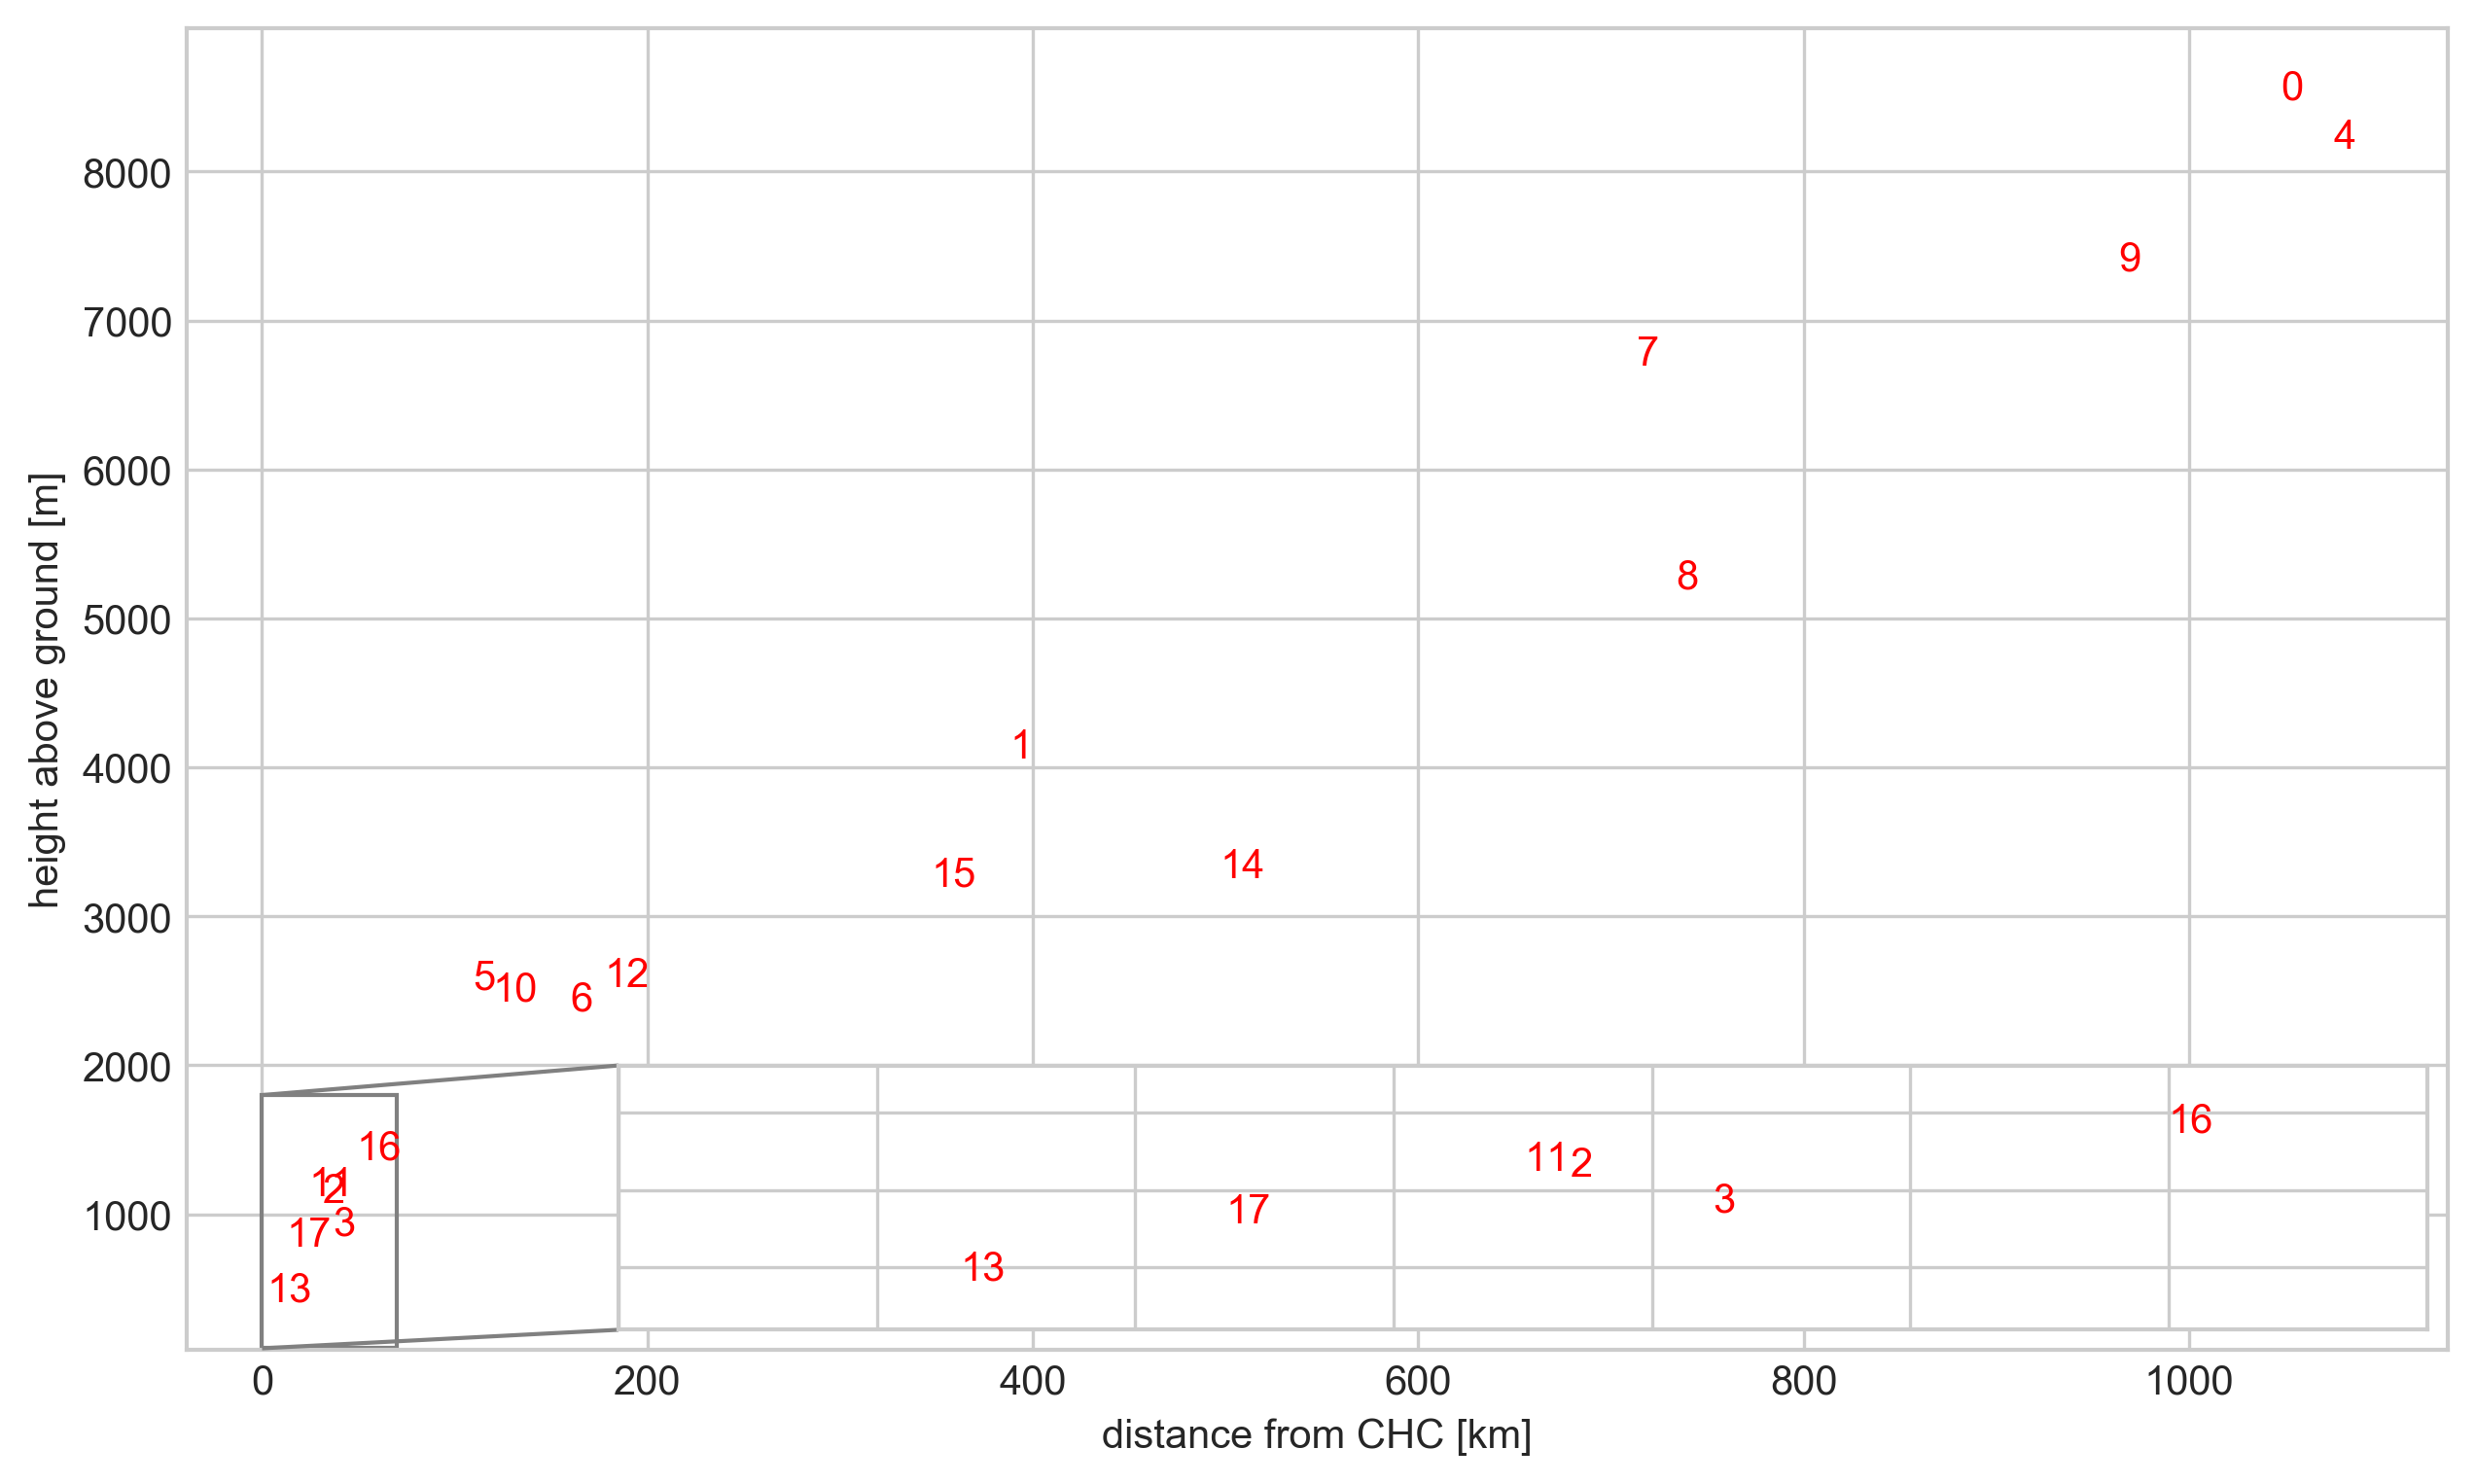

In [23]:
km_ = 'distance from CHC [km]'
hg_ = 'height above ground [m]'
df_prop[ km_ ] = df_prop[co.R_CENTER] * 100
df_prop[hg_] = df_prop[zm_topo]
f , ax = plt.subplots(figsize=(10,6))
ax: plt.Axes
xl = km_
yl = hg_
number_marker_plot( df_prop , xl , yl , ax )
axin = inset_axes(ax,'80%','20%', loc=4)


xmin = 0
xmax = 70
ymin = 100
ymax = 1800

_boo = (df_prop[yl]>ymin) & (df_prop[yl]<ymax) \
    & (df_prop[xl]>xmin) & (df_prop[xl]<xmax)

number_marker_plot( df_prop[_boo] , xl , yl , axin )
axin.set(xlim=(xmin,xmax),ylim=(ymin,ymax))
axin.xaxis.set_visible( 'False' )
axin.yaxis.set_visible( 'False' )
plt.yticks( visible=False )
plt.xticks( visible=False )
axin.set_xlabel(None)
axin.set_ylabel(None)
mark_inset( ax , axin , loc1=2 , loc2=3 , fc="none" , ec="0.5" )
# axin.set_xticks( visible=False )
# axin.set_yticks( visible=False )

plt.show()

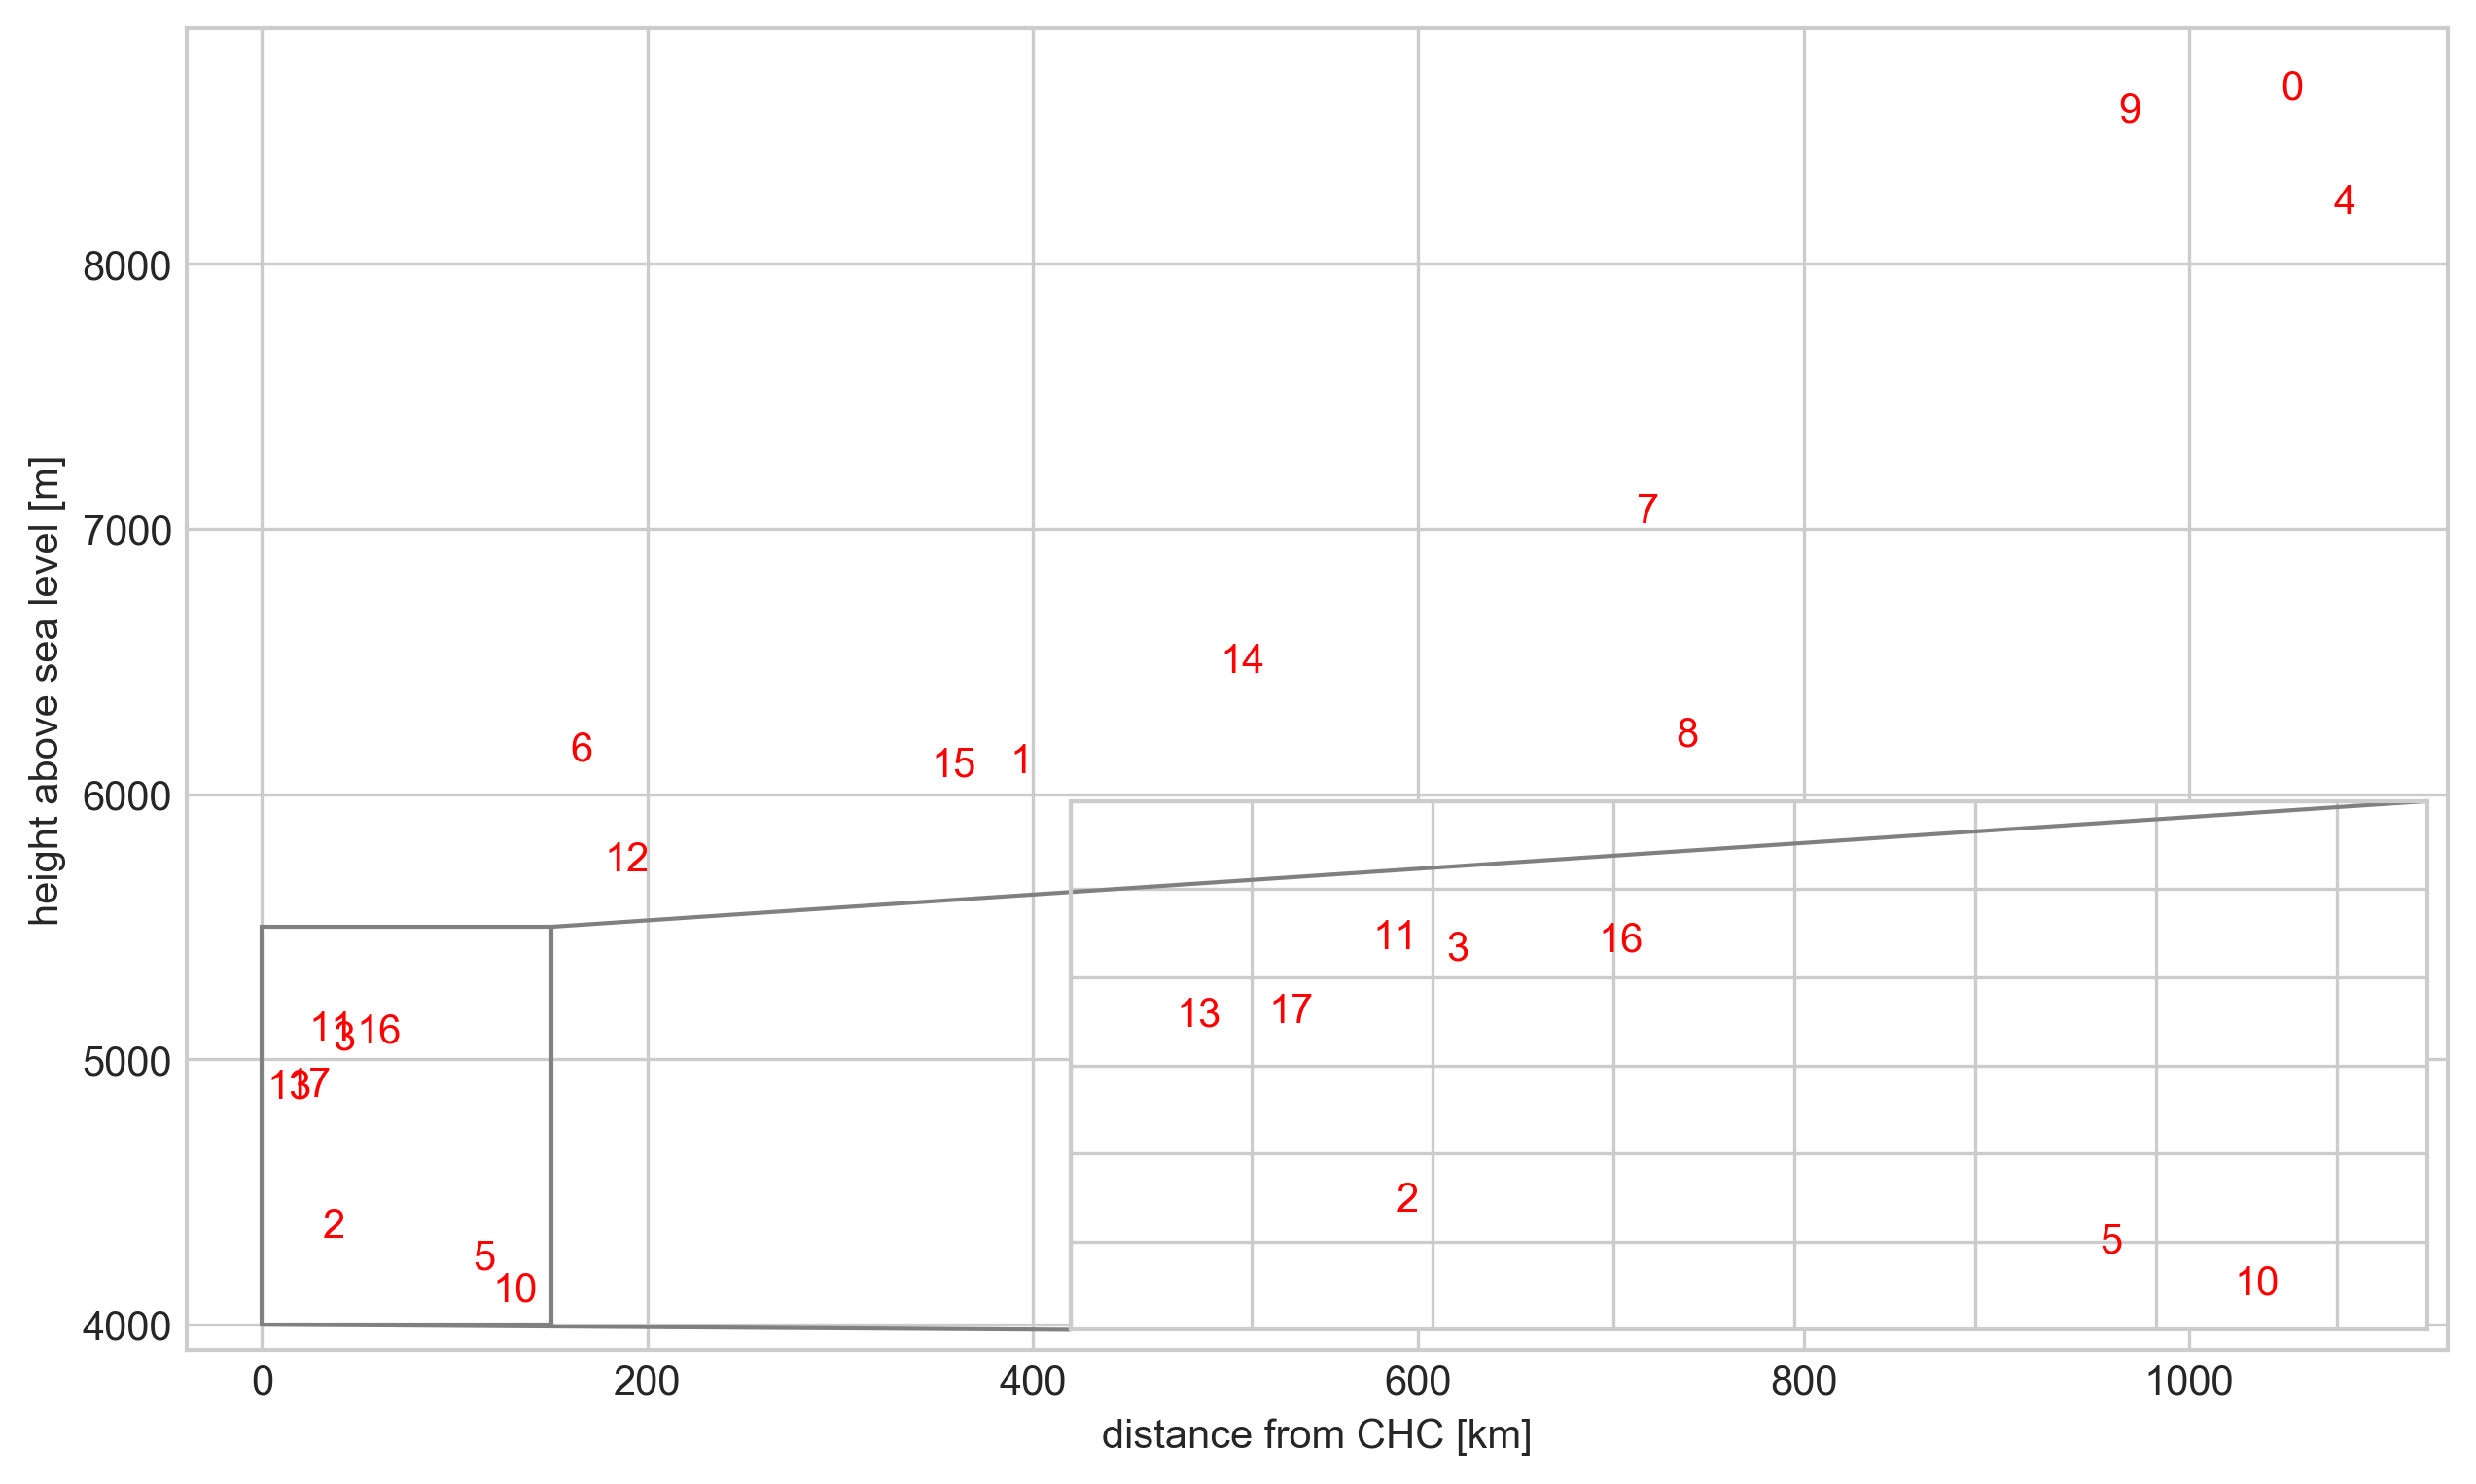

In [24]:
# km_ = 'distance from CHC [km]'
ha_ = 'height above sea level [m]'
# df_prop[ km_ ] = df_prop[co.R_CENTER] * 100
df_prop[ha_] = df_prop[co.ZM]
f , ax = plt.subplots(figsize=(10,6))
ax: plt.Axes
xl = km_
yl = ha_
number_marker_plot( df_prop , xl , yl , ax )
axin = inset_axes(ax,'60%','40%', loc=4)


xmin = 0
xmax = 150
ymin = 4000
ymax = 5500

_boo = (df_prop[yl]>ymin) & (df_prop[yl]<ymax) \
    & (df_prop[xl]>xmin) & (df_prop[xl]<xmax)

number_marker_plot( df_prop[_boo] , xl , yl , axin )
axin.set(xlim=(xmin,xmax),ylim=(ymin,ymax))

# number_marker_plot( df_prop , xl , yl , axin )
# axin.set(xlim=(0,150),ylim=(4000,5500))
axin.xaxis.set_visible( 'False' )
axin.yaxis.set_visible( 'False' )
plt.yticks( visible=False )
plt.xticks( visible=False )
axin.set_xlabel(None)
axin.set_ylabel(None)
mark_inset( ax , axin , loc1=1 , loc2=3 , fc="none" , ec="0.5" )
# axin.set_xticks( visible=False )
# axin.set_yticks( visible=False )

plt.show()

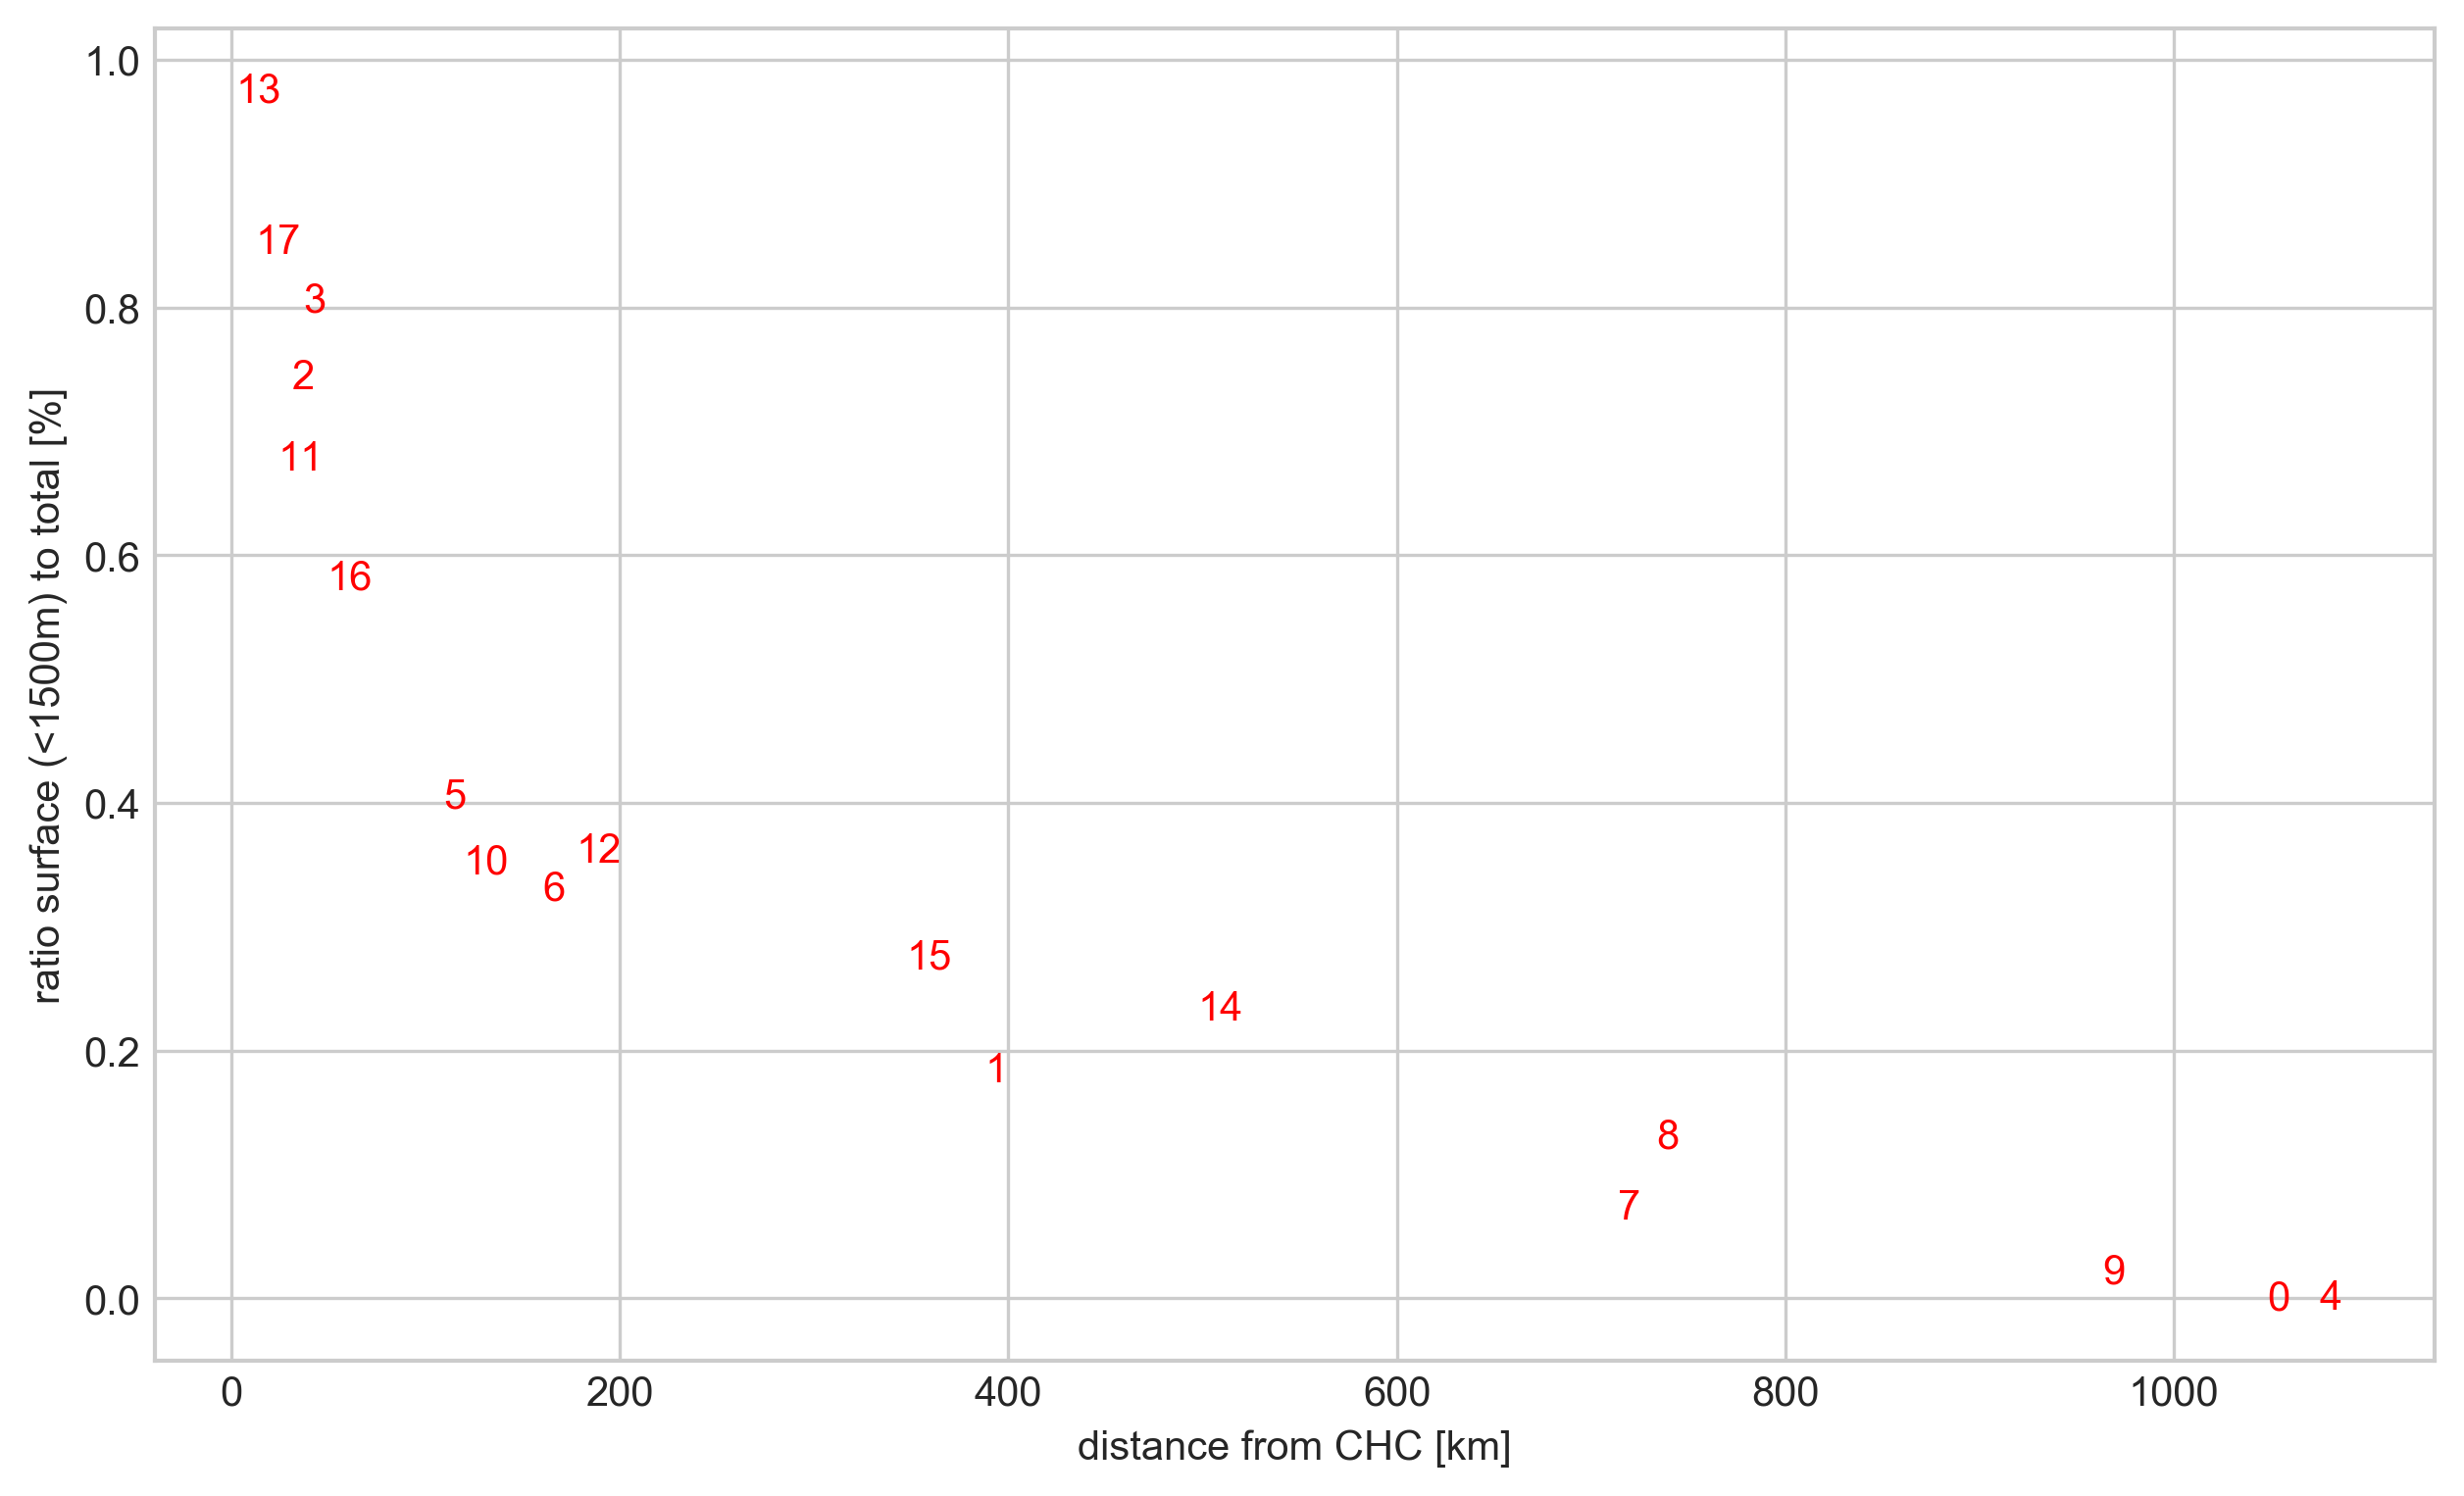

In [25]:
# df_prop.plot.scatter(x=co.R_CENTER,y=ratio_surf_tot_lab)
# f , ax = plt.subplots()

ax: plt.Axes
ratio_lab = 'ratio surface (<1500m) to total [%]'
df_prop[ ratio_lab ] = df_prop[ ratio_surf_tot_lab ]

# km_ = 'distance from CHC [km]'
ha_ = 'height above sea level [m]'
# df_prop[ km_ ] = df_prop[co.R_CENTER] * 100
# df_prop[ha_] = df_prop[co.ZM]
f , ax = plt.subplots(figsize=(10,6))
ax: plt.Axes
xl = km_
yl = ratio_lab
number_marker_plot( df_prop , xl , yl , ax )
# axin = inset_axes(ax,'60%','40%', loc=4)


# xmin = 0
# xmax = 150
# ymin = -1
# ymax = 1

# _boo = (df_prop[yl]>ymin) & (df_prop[yl]<ymax) \
#     & (df_prop[xl]>xmin) & (df_prop[xl]<xmax)

# number_marker_plot( df_prop[_boo] , xl , yl , axin )
# axin.set(xlim=(xmin,xmax),ylim=(ymin,ymax))

# number_marker_plot( df_prop , xl , yl , axin )
# axin.set(xlim=(0,150),ylim=(4000,5500))
# axin.xaxis.set_visible( 'False' )
# axin.yaxis.set_visible( 'False' )
# plt.yticks( visible=False )
# plt.xticks( visible=False )
# axin.set_xlabel(None)
# axin.set_ylabel(None)
# mark_inset( ax , axin , loc1=1 , loc2=3 , fc="none" , ec="0.5" )
# axin.set_xticks( visible=False )
# axin.set_yticks( visible=False )

# plt.show()

In [ ]:
df_prop['lat_chc'] =(df_prop[co.R_CENTER]*df_prop['Y'])+co.CHC_LAT
df_prop['lon_chc'] =(df_prop[co.R_CENTER]*df_prop['X'])+co.CHC_LON


ax=fa.get_ax_bolivia(
#     fig_args={'figsize':(8,8)}
)
# ax.legend()
xl = 'lon_chc'
yl = 'lat_chc'
def _plot(ax):
    df_prop.plot.scatter( x=xl , y=yl , alpha=1 , ax=ax ,c='white',s=100)
    for i , r in df_prop.iterrows() :
        # print( i )
        # r_km = r[ co.R_CENTER ]
        # ratio_per = r[ y_column ]
        t = ax.text(
            x=r[xl] ,
            y=r[yl] ,
            s=i , color='red' ,
            horizontalalignment='center' ,
            verticalalignment='center' ,
            fontdict={'size':13,'weight':'bold'},
    #         backgroundcolor='white', alpha=.5

            )
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
_plot(ax)








In [ ]:
df_prop['lat_chc'] =(df_prop[co.R_CENTER]*df_prop['Y'])+co.CHC_LAT
df_prop['lon_chc'] =(df_prop[co.R_CENTER]*df_prop['X'])+co.CHC_LON


ax=fa.get_ax_lapaz(
#     fig_args={'figsize':(8,8)}
)
# ax.legend()
xl = 'lon_chc'
yl = 'lat_chc'

xmin = -70
xmax = -66
ymin = -18
ymax = -13.5

_boo = (df_prop[yl]>ymin) & (df_prop[yl]<ymax) \
    & (df_prop[xl]>xmin) & (df_prop[xl]<xmax)


def _plot(ax):
    df_prop.plot.scatter( x=xl , y=yl , alpha=1 , ax=ax ,c='white',s=100)
    for i , r in df_prop[_boo].iterrows() :
        # print( i )
        # r_km = r[ co.R_CENTER ]
        # ratio_per = r[ y_column ]
        t = ax.text(
            x=r[xl] ,
            y=r[yl] ,
            s=i , color='red' ,
            horizontalalignment='center' ,
            verticalalignment='center' ,
            fontdict={'size':13,'weight':'bold'},
    #         backgroundcolor='white', alpha=.5

            )
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
_plot(ax)

In [ ]:
df_prop.to_excel('/tmp/excel.xls')